In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp, hour, minute
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import pandas as pd


In [3]:
spark = SparkSession.builder \
    .appName("Punkt") \
    .getOrCreate()

25/01/08 20:17:17 WARN util.Utils: Your hostname, node1 resolves to a loopback address: 127.0.0.1; using 10.0.2.15 instead (on interface enp0s3)
25/01/08 20:17:17 WARN util.Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/01/08 20:17:18 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [4]:
df = spark.read.format("parquet").load(f"hdfs://localhost:8020/user/vagrant/projekt/projektBD-20250108*")

In [5]:
df = df.drop('cloud_cover')
df = df.withColumn("processingTime", df["processingTime"].cast("string"))
df = df.withColumn("processingTime", df["processingTime"].substr(1, 12))

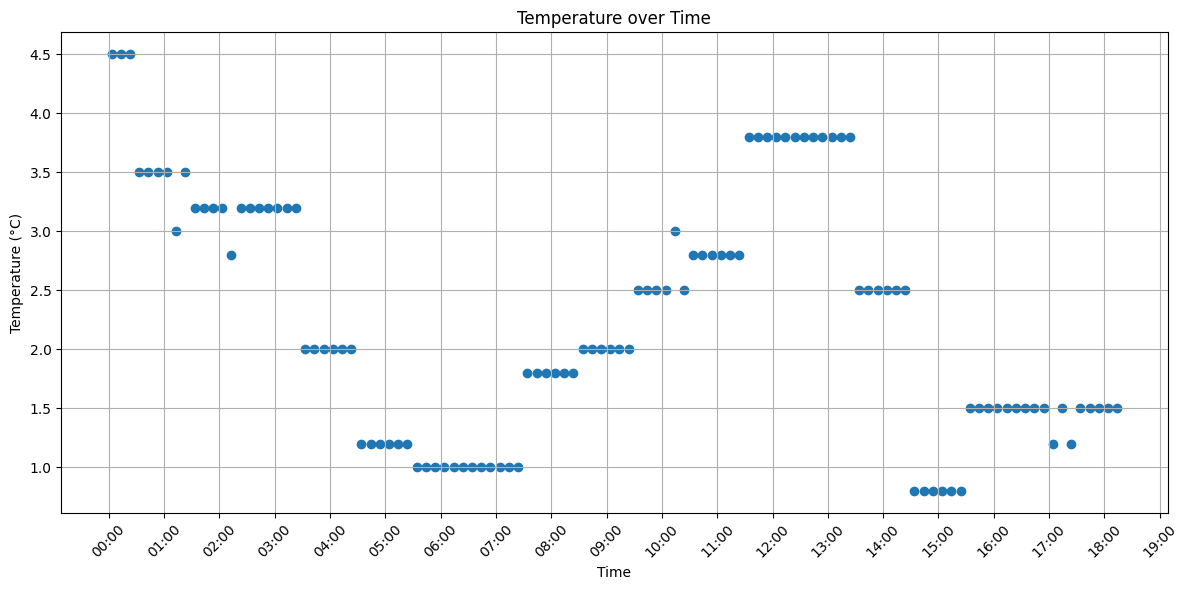

In [6]:
pandas_df = df.toPandas()
pandas_df['processingTime'] = pd.to_datetime(pandas_df['processingTime'], format='%Y%m%d%H%M')

plt.figure(figsize=(12, 6))
plt.scatter(pandas_df['processingTime'], pandas_df['temperature'], marker='o')

start_time = pandas_df['processingTime'].min().replace(minute=0, second=0)
end_time = pandas_df['processingTime'].max().replace(minute=0, second=0) + pd.Timedelta(hours=1)
hourly_ticks = pd.date_range(start=start_time, end=end_time, freq='h')

plt.xticks(hourly_ticks, hourly_ticks.strftime('%H:%M'), rotation=45)

plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('Temperature over Time')
plt.grid()

plt.tight_layout()
plt.savefig('Temperature_over_time')
plt.show()


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import contextily as ctx
import ipywidgets as widgets
from ipywidgets import interact
import time


df_pandas2 = df.toPandas()

df_pandas2["processingTime"] = pd.to_datetime(df_pandas2["processingTime"], format='%Y%m%d%H%M') 
df_pandas2 = df_pandas2.sort_values("processingTime") 

u = df_pandas2["wind_speed"] * np.cos(np.radians(df_pandas2["wind_angle"]))
v = df_pandas2["wind_speed"] * np.sin(np.radians(df_pandas2["wind_angle"]))

latitudes = [52.24] * len(df_pandas2)
longitudes = [21] * len(df_pandas2)

def plot_wind(selected_time):
    index = df_pandas2[df_pandas2["processingTime"] == selected_time].index[0]

    fig, ax = plt.subplots(figsize=(8, 8))
    
    ax.set_xlim(20.9, 21.1)
    ax.set_ylim(52.15, 52.35)
    ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.OpenStreetMap.Mapnik)
    
    norm = plt.Normalize(vmin=df_pandas2["wind_speed"].min(), vmax=df_pandas2["wind_speed"].max())
    sc = ax.quiver(longitudes[index], latitudes[index], u.iloc[index], v.iloc[index], df_pandas2["wind_speed"].iloc[index], cmap=cm.viridis, norm=norm, scale=20, width=0.03)
    
    plt.colorbar(sc)
    
    ax.set_axis_off()
    
    time_str = selected_time.strftime('%Y-%m-%d %H:%M')
    
    plt.title(f"Wektory wiatru w Warszawie - {time_str}")
    
    plt.show()

unique_times = df_pandas2["processingTime"].dt.strftime('%H:%M').tolist()
unique_datetimes = df_pandas2["processingTime"].tolist()

time_selector = widgets.SelectionSlider(
    options=list(zip(unique_times, unique_datetimes)),
    description='Czas:',
    style={'description_width': 'initial'},
    layout={'width': '600px'}
)

interact(plot_wind, selected_time=time_selector)


/home/vagrant/.local/lib/python3.9/site-packages/requests/__init__.py:113: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (2.3.0)/charset_normalizer (3.4.0) doesn't match a supported version!
  warnings.warn(
                                                                                

interactive(children=(SelectionSlider(description='Czas:', layout=Layout(width='600px'), options=(('00:03', Ti…

<function __main__.plot_wind(selected_time)>